In [1]:
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt

[0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.    1.025 1.05  1.075 1.1   1.125 1.15  1.175
 1.2   1.225 1.25  1.275 1.3   1.325 1.35  1.375 1.4   1.425 1.45  1.475
 1.5   1.525 1.55  1.575 1.6   1.625 1.65  1.675 1.7   1.725 1.75  1.775
 1.8   1.825 1.85  1.875 1.9   1.925 1.95  1.975 2.   ]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]


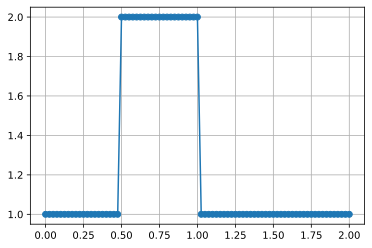

In [2]:
nx = 81 # tente mudar este número de 41 para 81 e rodar tudo novamente ... o que acontece?
dx = 2/(nx-1)
nt = 25
dt = .02
c = 1 # suponha velocidade da onda c = 1
x = np.linspace(0,2,nx)
u = np.ones(nx)      # numpy function ones()
u[int(.5 / dx):int(1 / dx + 1)] = 2  # setting u = 2 between 0.5 and 1 as per our I.C.s
print(x)
print(u)
plt.plot(x,u,'o-')
plt.grid()

In [3]:
un = np.ones(nx) #initialize a temporary array

for n in range(nt):  #loop for values of n from 0 to nt, so it will run nt times
    un = u.copy() ##copy the existing values of u into un
    for i in range(1, nx): ## you can try commenting this line and...
    #for i in range(nx): ## ... uncommenting this line and see what happens!
        u[i] = un[i] - c * dt / dx * (un[i] - un[i-1])

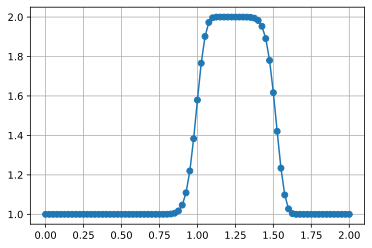

In [4]:
plt.plot(x, u, 'o-')
plt.grid()

## Implementação com Devito

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.] (2, 81) 162


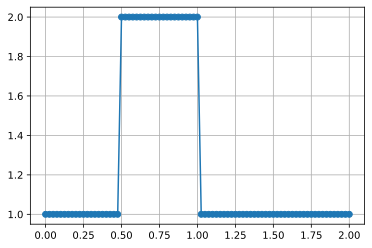

In [5]:
#NBVAL_IGNORE_OUTPUT
from examples.cfd import plot_field, init_hat
from devito import Grid, TimeFunction

grid = Grid(shape=(nx,), extent=(2.,))
u = TimeFunction(name='u', grid=grid)

u.data[0][:] = 1.
u.data[0][int(.5 / dx):int(1 / dx + 1)] = 2.
# Note que u.data[0] == u.data[0,:]
print(u.data[0],u.data.shape,u.data.size)
plt.plot(x,u.data[0],'o-')
plt.grid()

In [6]:
from devito import Eq

# Specify the `interior` flag so that the stencil is only
# applied to the interior of the domain.
eq = Eq(u.dt + c*u.dxl, subdomain=grid.interior)

print(eq)
eq

Eq(Derivative(u(t, x), x) + Derivative(u(t, x), t), 0)


Eq(Derivative(u(t, x), x) + Derivative(u(t, x), t), 0)

In [7]:
u.forward

u(t + dt, x)

In [8]:
from devito import solve
from sympy import nsimplify, pprint

stencil = solve(eq, u.forward)

pprint(stencil)

   ⎛  ∂             u(t, x)⎞
dt⋅⎜- ──(u(t, x)) + ───────⎟
   ⎝  ∂x               dt  ⎠


In [9]:
#NBVAL_IGNORE_OUTPUT
from devito import Operator

# Reset our initial condition in both buffers.
# This is required to avoid 0s propagating into
# our solution, which has a background value of 1.
for i in range(u.data.shape[0]):
    u.data[i][:] = 1.
    u.data[i][int(.5 / dx):int(1 / dx + 1)] = 2.

# Create an operator that updates the forward stencil point
op = Operator(Eq(u.forward, stencil, subdomain=grid.interior))

# Apply the operator for a number of timesteps
op.apply(time=nt, dt=dt)

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=1.3000000000000003e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

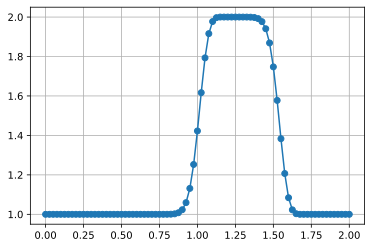

In [10]:
plt.plot(np.linspace(0, 2, nx), u.data[0], 'o-')
plt.grid()

In [11]:
print(op.ccode)

#define _POSIX_C_SOURCE 200809L
#define START_TIMER(S) struct timeval start_ ## S , end_ ## S ; gettimeofday(&start_ ## S , NULL);
#define STOP_TIMER(S,T) gettimeofday(&end_ ## S, NULL); T->S += (double)(end_ ## S .tv_sec-start_ ## S.tv_sec)+(double)(end_ ## S .tv_usec-start_ ## S .tv_usec)/1000000;

#include "stdlib.h"
#include "math.h"
#include "sys/time.h"
#include "xmmintrin.h"
#include "pmmintrin.h"

struct dataobj
{
  void *restrict data;
  int * size;
  int * npsize;
  int * dsize;
  int * hsize;
  int * hofs;
  int * oofs;
} ;

struct profiler
{
  double section0;
} ;


int Kernel(const float dt, const float h_x, struct dataobj *restrict u_vec, const int i0x_ltkn, const int i0x_rtkn, const int time_M, const int time_m, const int x_M, const int x_m, struct profiler * timers)
{
  float (*restrict u)[u_vec->size[1]] __attribute__ ((aligned (64))) = (float (*)[u_vec->size[1]]) u_vec->data;

  /* Flush denormal numbers to zero in hardware */
  _MM_SET_DENORMALS_ZERO_MODE(_MM_DENORMA

### Outra condição inicial

0.025


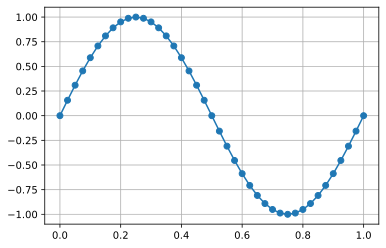

In [12]:
nx = 41
L = 1.0
dx = L/(nx-1)
print(dx)
x = np.linspace(0,L,nx)
u = np.sin(2.0*np.pi*x)
plt.plot(x,u,'-o')
plt.grid()

0.025 40
41 (41,)


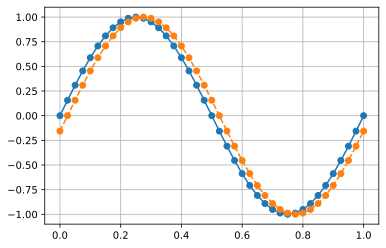

In [13]:
c = 1.0 # m/s - wave speed
dt = dx/c  # run just at the CFL condition
cfl = c*dt/dx
print(dt, int(1./dt))

un = u.copy() ##copy the existing values of u into un
u[1:-1] = un[1:-1] - cfl * (un[1:-1] - un[:-2])
u[-1] = un[-1] - cfl*(un[-1] - un[-2]) # compute last point on the right using periodicity
u[0] = u[-1] # set periodic boundary on the left
print(u.size,u.shape)
plt.plot(x,un,'-o',x,u,'--o')
plt.grid()

[ 0.0000000e+00  1.5643446e-01  3.0901700e-01  4.5399049e-01
  5.8778524e-01  7.0710677e-01  8.0901700e-01  8.9100653e-01
  9.5105654e-01  9.8768836e-01  1.0000000e+00  9.8768836e-01
  9.5105654e-01  8.9100653e-01  8.0901700e-01  7.0710677e-01
  5.8778524e-01  4.5399049e-01  3.0901700e-01  1.5643446e-01
  1.2246469e-16 -1.5643446e-01 -3.0901700e-01 -4.5399049e-01
 -5.8778524e-01 -7.0710677e-01 -8.0901700e-01 -8.9100653e-01
 -9.5105654e-01 -9.8768836e-01 -1.0000000e+00 -9.8768836e-01
 -9.5105654e-01 -8.9100653e-01 -8.0901700e-01 -7.0710677e-01
 -5.8778524e-01 -4.5399049e-01 -3.0901700e-01 -1.5643446e-01
 -2.4492937e-16] (2, 41) 82


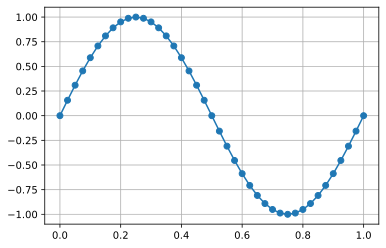

In [14]:
grid = Grid(shape=(nx,), extent=(1.,))
u = TimeFunction(name='u', grid=grid)

u.data[0][:] = np.sin(2.0*np.pi*x)
# Note que u.data[0] == u.data[0,:]
print(u.data[0],u.data.shape,u.data.size)
plt.plot(x,u.data[0],'o-')
plt.grid()

In [15]:
eq = Eq(u.dt + c*u.dxl, subdomain=grid.interior)

stencil = solve(eq, u.forward)
update = Eq(u.forward, stencil)#, subdomain=grid.interior)
update

Eq(u(t + dt, x), dt*(-1.0*Derivative(u(t, x), x) + u(t, x)/dt))

In [16]:
x = grid.dimensions
t = grid.stepping_dim
bc_left = Eq(u[t + 1, 0], u[t + 1, nx-1])

In [17]:
for i in range(u.data.shape[0]):
    u.data[i][:] = np.sin(2.0*np.pi*np.linspace(0,L,nx))
    
#op2 = Operator([update], opt='noop')
op2 = Operator([update]+[bc_left], opt='noop')
op2(time=0, dt=dt)

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=1e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

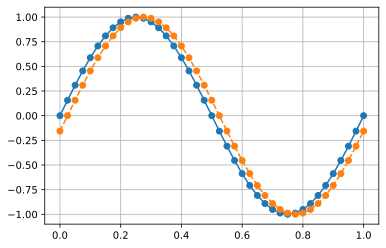

In [18]:
plt.plot(np.linspace(0,L,nx),u.data[0],'o-',np.linspace(0,L,nx),u.data[1],'--o')
plt.grid()

In [19]:
print(op2.ccode)

#define _POSIX_C_SOURCE 200809L
#define START_TIMER(S) struct timeval start_ ## S , end_ ## S ; gettimeofday(&start_ ## S , NULL);
#define STOP_TIMER(S,T) gettimeofday(&end_ ## S, NULL); T->S += (double)(end_ ## S .tv_sec-start_ ## S.tv_sec)+(double)(end_ ## S .tv_usec-start_ ## S .tv_usec)/1000000;

#include "stdlib.h"
#include "math.h"
#include "sys/time.h"

struct dataobj
{
  void *restrict data;
  int * size;
  int * npsize;
  int * dsize;
  int * hsize;
  int * hofs;
  int * oofs;
} ;

struct profiler
{
  double section0;
} ;


int Kernel(const float dt, const float h_x, struct dataobj *restrict u_vec, const int time_M, const int time_m, const int x_M, const int x_m, struct profiler * timers)
{
  float (*restrict u)[u_vec->size[1]] __attribute__ ((aligned (64))) = (float (*)[u_vec->size[1]]) u_vec->data;

  for (int time = time_m, t0 = (time)%(2), t1 = (time + 1)%(2); time <= time_M; time += 1, t0 = (time)%(2), t1 = (time + 1)%(2))
  {
    /* Begin section0 */
    START_TIMER(sect

In [20]:
for i in range(u.data.shape[0]):
    u.data[i][:] = np.sin(2.0*np.pi*np.linspace(0,L,nx))
    
op2(time=nt, dt=dt)

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=9e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

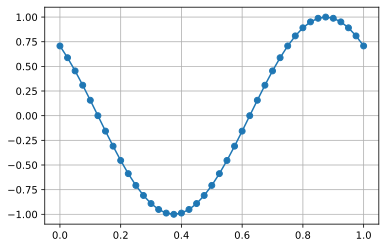

In [21]:
plt.plot(np.linspace(0,L,nx),u.data[1],'o-')
plt.grid()